In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("./digit-recognizer/train.csv").values
X = df[0:, 1:]
y = df[0:, :1]

# Normalizar
X = (X / 255.0).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [20]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=8, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def kmeans_plusplus(self, X: np.ndarray):
        n_samples, n_features = X.shape

        # Initialize centroids array
        centroids = np.empty((self.n_clusters, n_features), dtype=X.dtype)

        # Step 1: Randomly select the first centroid
        initial_idx = np.random.randint(n_samples)
        centroids[0] = X[initial_idx]

        # Step 2: Initialize list to store distances to nearest centroid
        nearest_distances = np.full(n_samples, np.inf)

        for i in range(1, self.n_clusters):
            # Step 3: Calculate distances to nearest centroid
            distances = np.linalg.norm(X - centroids[i - 1], axis=1) ** 2
            nearest_distances = np.minimum(nearest_distances, distances)

            # Step 4: Compute probability distribution
            probabilities = nearest_distances / np.sum(nearest_distances)

            # Step 5: Select next centroid randomly according to probabilities
            centroid_idx = np.random.choice(n_samples, p=probabilities)
            centroids[i] = X[centroid_idx]

        return centroids

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        # Initialize centroids
        self.centroids_ = self.kmeans_plusplus(X)
        count = 0
        while 1:
            # Assign labels based on closest centroid
            self.labels_ = self._assign_labels(X)

            # Calculate new centroids from the means of the points
            new_centroids = np.array(
                [X[self.labels_ == j].mean(axis=0) for j in range(self.n_clusters)]
            )

            # Check for convergence
            if np.allclose(self.centroids_, new_centroids, atol=self.tol):
                break

            self.centroids_ = new_centroids
        return self

    def predict(self, X):
        return self._assign_labels(X)

    def _assign_labels(self, X):
        distances = self.transform(X)
        return np.argmin(distances, axis=1)

    def transform(self, X):
        return np.linalg.norm(X[:, np.newaxis] - self.centroids_, axis=2)

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)


def show_centroids(centroids, count, size):
    fig, axs = plt.subplots(1, size, figsize=(15, 1.5))
    for i, ax in enumerate(axs):
        ax.imshow(centroids[i].reshape(28, 28), cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Iteração: {count}")
    plt.show()

In [19]:
def plot_silhouette_scores(X, k_values):
    silhouette_scores = []

    for k in k_values:
        kmeans = CustomKMeans(n_clusters=k)
        kmeans.fit(X)
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

        print(
            f"For n_clusters = {k}, the average silhouette score is {silhouette_avg:.4f}"
        )

    # Plotting the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker="o")
    plt.title("Silhouette Scores for Different Values of k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

In [21]:
kmeans = CustomKMeans(n_clusters=2)
kmeans.fit(X_scaled)
kmeans.labels_

DOne


array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

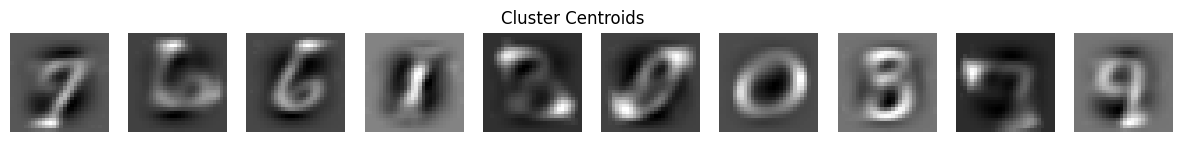

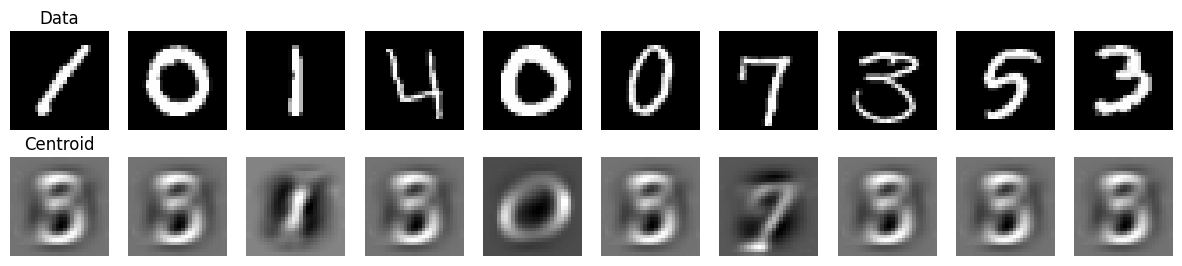

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(15, 1.5))
centroids = kmeans.centroids_
for i, ax in enumerate(axs):
    ax.imshow(centroids[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.suptitle("Cluster Centroids")
plt.show()

# Plot some data images and their assigned centroid images
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    ax = axs[0, i]
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    if i == 0:
        ax.set_title("Data")

    ax = axs[1, i]
    centroid_idx = kmeans.predict(X[i].reshape(1, -1))
    ax.imshow(centroids[centroid_idx].reshape(28, 28), cmap="gray")
    ax.axis("off")
    if i == 0:
        ax.set_title("Centroid")

DOne
For n_clusters = 2, the average silhouette score is 0.1280
DOne
For n_clusters = 3, the average silhouette score is 0.1280
DOne
For n_clusters = 4, the average silhouette score is 0.0385
DOne
For n_clusters = 5, the average silhouette score is 0.0075
DOne
For n_clusters = 6, the average silhouette score is 0.0316
DOne
For n_clusters = 7, the average silhouette score is -0.0104
DOne
For n_clusters = 8, the average silhouette score is -0.0048
DOne
For n_clusters = 9, the average silhouette score is 0.0054
DOne
For n_clusters = 10, the average silhouette score is 0.0001


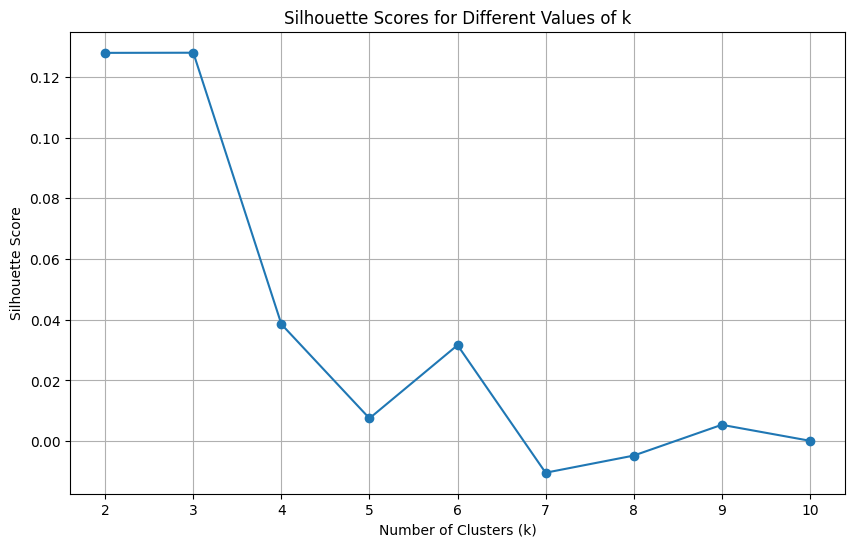

In [23]:
plot_silhouette_scores(X_scaled, range(2, 11))